# Imports

In [1]:
import json
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import os

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix

from ddagl import graph_level_nn, graph_feature_extraction, evaluation

Using backend: pytorch


# Data Acquisition

In [2]:
if not os.path.exists('datasets/odds/ODDS.json'):
    from urllib import request
    request.urlretrieve('https://zenodo.org/record/4633704/files/ODDS.json',
                        'datasets/odds/ODDS.json')

with open('datasets/odds/ODDS.json', 'r') as fp:
    graphs = pd.Series(list(map(nx.node_link_graph, json.load(fp)['graphs'])), dtype=object)

_Relevant_ workflows are those with a minimum of 5 nodes, 5 or more versions and only those that are connected.

In [4]:
relevant_graphs_sub = evaluation.version_subsampling(graphs, subsampling_factor=10)
del graphs

cs_graphs, cs_labels = evaluation.prepare_for_component_suggestion(relevant_graphs_sub, 
                                                                   drop_attrs=('config', 'name', 'description'))

del relevant_graphs_sub
groups = [g.graph['id'] for g in cs_graphs]
cs_nodes = [g.graph['node'] for g in cs_graphs]

# Setup

In [5]:
cv = GroupShuffleSplit(random_state=42)

def cv_score(est, X, y, groups=groups, cv = cv, show_training_history: bool = False, plot_predictions:bool = False,
            set_est_random_state:bool = True, print_results:bool = True):  
    score_dicts = []
    for random_state, (train_ind, test_ind) in enumerate(cv.split(X, y, groups=groups)):
        X_train, y_train = X[train_ind], y[train_ind]
        X_test, y_test = X[test_ind], y[test_ind]
        if set_est_random_state and type(est) is Pipeline and hasattr(est.steps[-1][-1], 'random_state'):
            est.steps[-1][-1].random_state = random_state
            
        est.fit(X_train, y_train)
        
        if show_training_history and type(est) is Pipeline and hasattr(est.steps[-1][-1], 'show_training_history'):
            est.steps[-1][-1].show_training_history(figsize=(8, 5), epoch_cutoff=.5)
            plt.show()
        
        y_pred = est.predict(X_test)
        top_5_accuracy = top_n_scorer(est, X_test, y_test)
        accuracy = accuracy_score(y_test, y_pred)
        score_dicts.append(dict(accuracy=accuracy, top_5_accuracy=top_5_accuracy))
        print(score_dicts[-1])
        if plot_predictions:
            plt.figure(figsize = (7,6), dpi = 200)
            sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', square=True)
            plt.show()
    
    scores_df = pd.DataFrame(score_dicts)
    if print_results:
        print(scores_df.aggregate((np.mean, np.std)))
    return scores_df

# Basic Classifiers

In [17]:
nlfe = graph_feature_extraction.NodeLevelFeatureExtractor(n_jobs=16)
if not os.path.exists('cs_node_level_df.csv'):
    node_level_df = nlfe.fit_transform(zip(cs_graphs, cs_nodes))
    node_level_df.to_csv('cs_node_level_df.csv')
else:
    node_level_df = pd.read_csv('cs_node_level_df.csv')

In [18]:
dc = DummyClassifier(strategy='prior')
sgd_pipeline = make_pipeline(StandardScaler(), SGDClassifier(n_jobs = 4, loss='log'))
rf = RandomForestClassifier(random_state=42, n_jobs = 4)

clfs = [rf, sgd_pipeline, dc]
                  
    
score_dfs = []

for clf in clfs:
    name = clf.steps[-1][-1].__class__.__name__ if type(clf) is Pipeline else clf.__class__.__name__
    score_df = cv_score(clf, node_level_df.values, y=cs_labels, print_results=False)
    score_df['classifier'] = name
    score_dfs.append(score_df)                  
classifier_comparison_df = pd.concat(score_dfs)

{'accuracy': 0.5015349194167307, 'top_5_accuracy': 0.772831926323868}
{'accuracy': 0.47527910685805425, 'top_5_accuracy': 0.689792663476874}
{'accuracy': 0.4794952681388013, 'top_5_accuracy': 0.729903187207658}
{'accuracy': 0.32640144665461124, 'top_5_accuracy': 0.6121157323688969}
{'accuracy': 0.5243847874720358, 'top_5_accuracy': 0.768903803131991}
{'accuracy': 0.17613200306983884, 'top_5_accuracy': 0.5809669992325402}
{'accuracy': 0.20414673046251994, 'top_5_accuracy': 0.5598086124401914}
{'accuracy': 0.1498966605025563, 'top_5_accuracy': 0.45958881757859243}
{'accuracy': 0.189873417721519, 'top_5_accuracy': 0.4891500904159132}
{'accuracy': 0.17651006711409395, 'top_5_accuracy': 0.5469798657718121}
{'accuracy': 0.3319263238679969, 'top_5_accuracy': 0.5280122793553338}
{'accuracy': 0.27791068580542266, 'top_5_accuracy': 0.4094896331738437}
{'accuracy': 0.17687370825628196, 'top_5_accuracy': 0.47677580767975636}
{'accuracy': 0.21428571428571427, 'top_5_accuracy': 0.45569620253164556}


In [19]:
classifier_comparison_df.groupby('classifier').aggregate(['mean', 'std']).sort_values(('top_5_accuracy', 'mean'))

accuracy           top_5_accuracy          
                            mean       std           mean       std
classifier                                                         
DummyClassifier         0.260065  0.063326       0.472787  0.044195
SGDClassifier           0.179312  0.020072       0.527299  0.050903
RandomForestClassifier  0.461419  0.077978       0.714709  0.066506

# P-GCN

## Setup

In [6]:
feature_transformer = graph_feature_extraction.NodeLevelFeatureTransformer(use_configs=False, 
                                                                           node_id_column = 'node')
gcn_default_kwargs = dict(nb_epochs=50, random_state=42, batch_size = 5000, inference_batch_size = 500,
                          scoring = accuracy_score, dropout = 0.25)

## Hybrid P-GCN

epoch 000 | lr 0.01000 | loss 3.37217 | loss_std 0.55176 | train_score 0.22411
epoch 001 | lr 0.00950 | loss 2.72370 | loss_std 0.08379 | train_score 0.30493
epoch 002 | lr 0.00903 | loss 2.40516 | loss_std 0.07967 | train_score 0.36917
epoch 003 | lr 0.00857 | loss 2.05844 | loss_std 0.10060 | train_score 0.44797
epoch 004 | lr 0.00815 | loss 1.75418 | loss_std 0.08063 | train_score 0.51805
epoch 005 | lr 0.00774 | loss 1.54029 | loss_std 0.06798 | train_score 0.56972
epoch 006 | lr 0.00735 | loss 1.35742 | loss_std 0.05299 | train_score 0.61855
epoch 007 | lr 0.00698 | loss 1.21632 | loss_std 0.04905 | train_score 0.65174
epoch 008 | lr 0.00663 | loss 1.14321 | loss_std 0.03489 | train_score 0.66779
epoch 009 | lr 0.00630 | loss 1.04170 | loss_std 0.03211 | train_score 0.69124
epoch 010 | lr 0.00599 | loss 0.96698 | loss_std 0.01788 | train_score 0.70875
epoch 011 | lr 0.00569 | loss 0.91368 | loss_std 0.01786 | train_score 0.72133
epoch 012 | lr 0.00540 | loss 0.86020 | loss_std 0.0

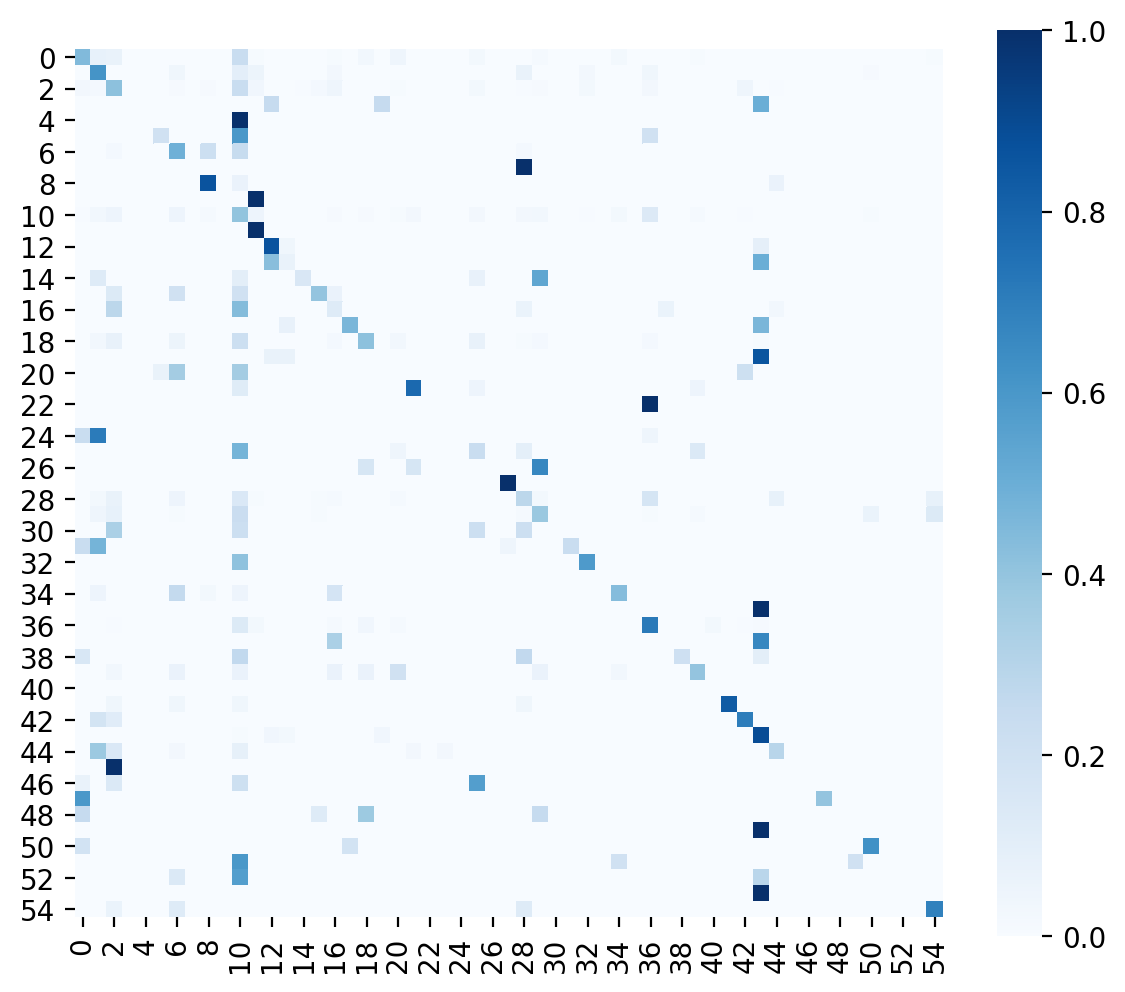

epoch 000 | lr 0.01000 | loss 3.33046 | loss_std 0.58234 | train_score 0.23607
epoch 001 | lr 0.00950 | loss 2.63240 | loss_std 0.10705 | train_score 0.33402
epoch 002 | lr 0.00903 | loss 2.29057 | loss_std 0.10359 | train_score 0.40690
epoch 003 | lr 0.00857 | loss 1.96729 | loss_std 0.10217 | train_score 0.47557
epoch 004 | lr 0.00815 | loss 1.68194 | loss_std 0.06190 | train_score 0.53598
epoch 005 | lr 0.00774 | loss 1.51135 | loss_std 0.06629 | train_score 0.57977
epoch 006 | lr 0.00735 | loss 1.33091 | loss_std 0.04646 | train_score 0.62557
epoch 007 | lr 0.00698 | loss 1.18138 | loss_std 0.03497 | train_score 0.65877
epoch 008 | lr 0.00663 | loss 1.05705 | loss_std 0.03167 | train_score 0.69018
epoch 009 | lr 0.00630 | loss 0.97985 | loss_std 0.01500 | train_score 0.71133
epoch 010 | lr 0.00599 | loss 0.91872 | loss_std 0.02004 | train_score 0.72402
epoch 011 | lr 0.00569 | loss 0.84963 | loss_std 0.01560 | train_score 0.74124
epoch 012 | lr 0.00540 | loss 0.81513 | loss_std 0.0

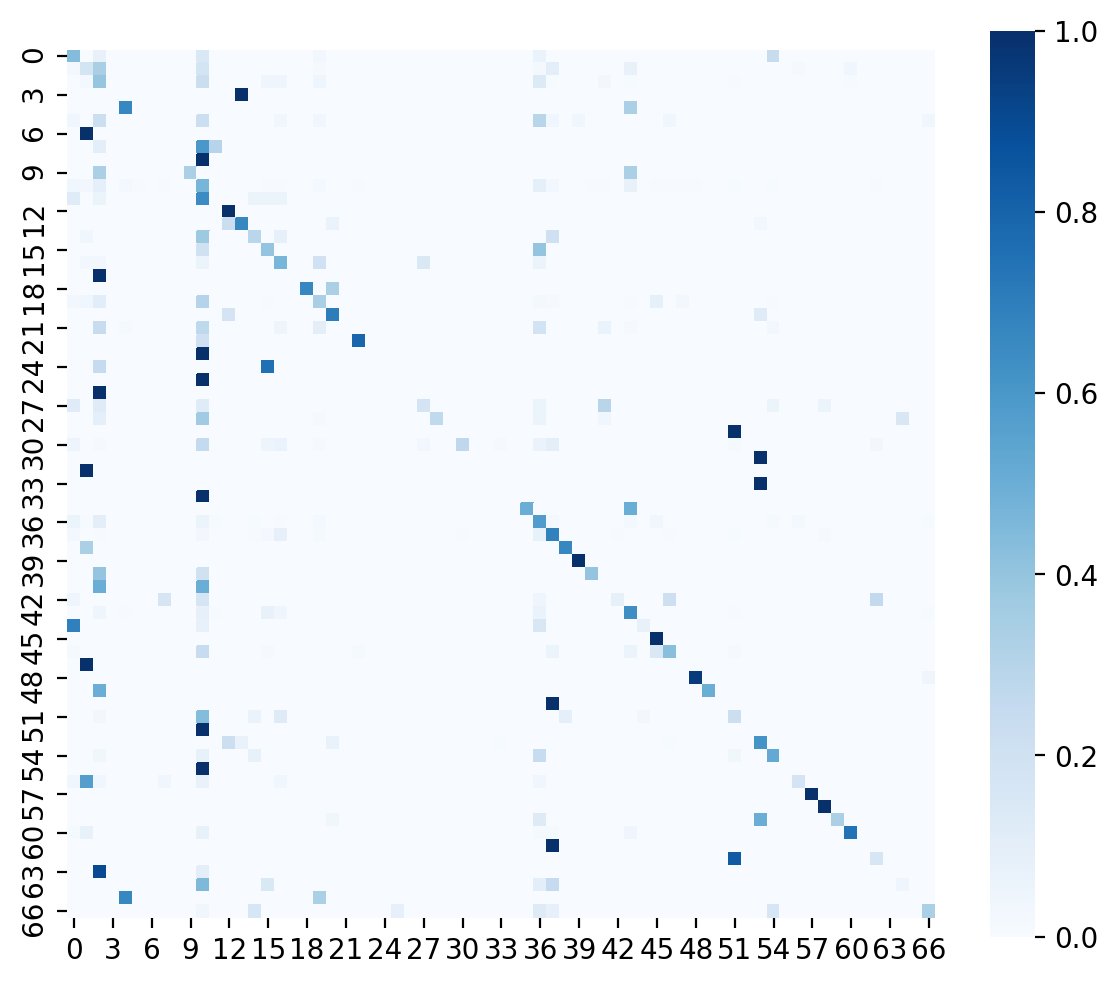

epoch 000 | lr 0.01000 | loss 3.42786 | loss_std 0.54921 | train_score 0.22274
epoch 001 | lr 0.00950 | loss 2.78397 | loss_std 0.08548 | train_score 0.30091
epoch 002 | lr 0.00903 | loss 2.48510 | loss_std 0.06873 | train_score 0.34976
epoch 003 | lr 0.00857 | loss 2.16512 | loss_std 0.09340 | train_score 0.42081
epoch 004 | lr 0.00815 | loss 1.90131 | loss_std 0.08012 | train_score 0.47977
epoch 005 | lr 0.00774 | loss 1.67532 | loss_std 0.04980 | train_score 0.53160
epoch 006 | lr 0.00735 | loss 1.49337 | loss_std 0.07224 | train_score 0.57304
epoch 007 | lr 0.00698 | loss 1.37446 | loss_std 0.05074 | train_score 0.60026
epoch 008 | lr 0.00663 | loss 1.24028 | loss_std 0.04319 | train_score 0.63592
epoch 009 | lr 0.00630 | loss 1.16861 | loss_std 0.04352 | train_score 0.64802
epoch 010 | lr 0.00599 | loss 1.11370 | loss_std 0.03778 | train_score 0.65651
epoch 011 | lr 0.00569 | loss 1.03752 | loss_std 0.03349 | train_score 0.68031
epoch 012 | lr 0.00540 | loss 0.96748 | loss_std 0.0

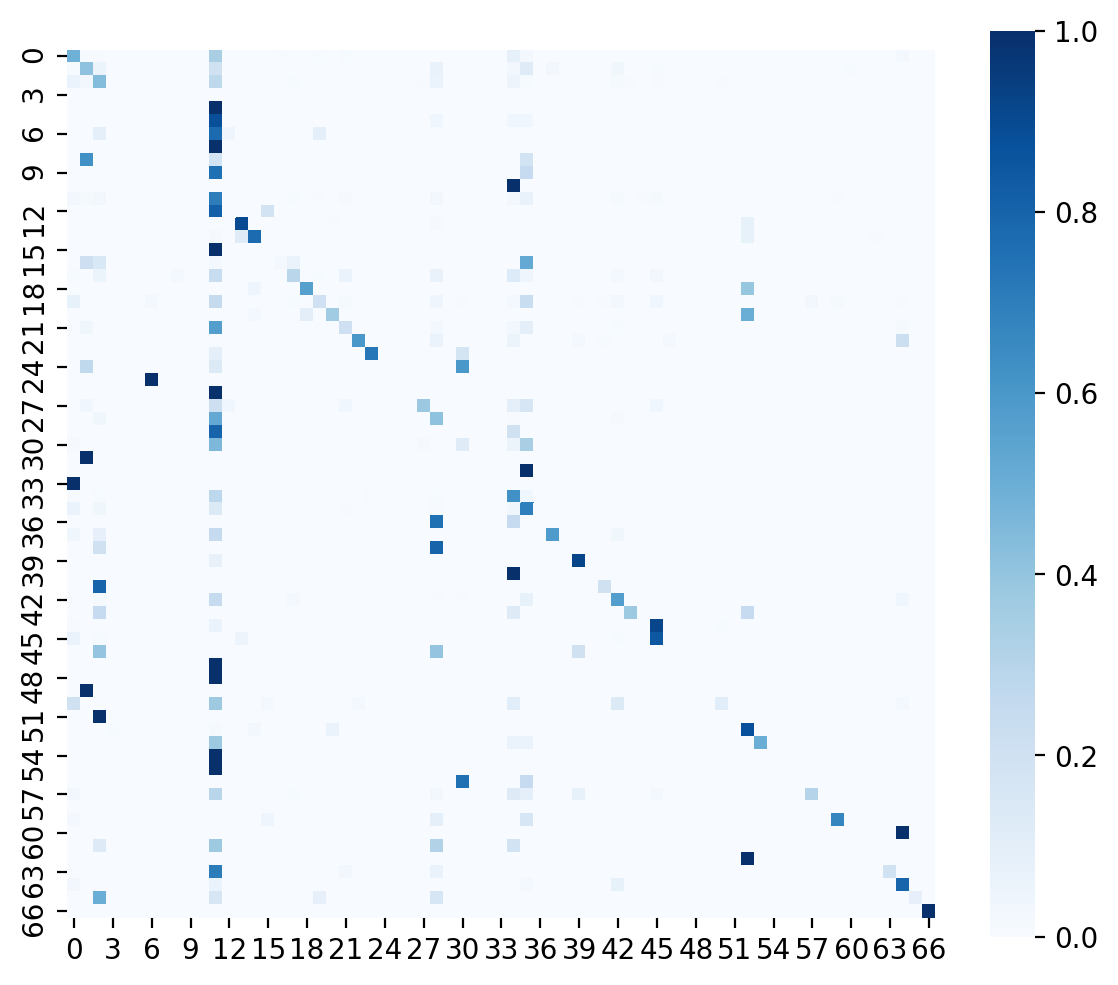

epoch 000 | lr 0.01000 | loss 3.41159 | loss_std 0.64955 | train_score 0.23973
epoch 001 | lr 0.00950 | loss 2.60020 | loss_std 0.09842 | train_score 0.34941
epoch 002 | lr 0.00903 | loss 2.24856 | loss_std 0.09479 | train_score 0.42164
epoch 003 | lr 0.00857 | loss 1.91429 | loss_std 0.08556 | train_score 0.48888
epoch 004 | lr 0.00815 | loss 1.62766 | loss_std 0.08430 | train_score 0.55165
epoch 005 | lr 0.00774 | loss 1.42493 | loss_std 0.05549 | train_score 0.60018
epoch 006 | lr 0.00735 | loss 1.26767 | loss_std 0.03699 | train_score 0.63701
epoch 007 | lr 0.00698 | loss 1.15316 | loss_std 0.03435 | train_score 0.66723
epoch 008 | lr 0.00663 | loss 1.05791 | loss_std 0.04073 | train_score 0.69062
epoch 009 | lr 0.00630 | loss 0.97070 | loss_std 0.03467 | train_score 0.70807
epoch 010 | lr 0.00599 | loss 0.89927 | loss_std 0.02625 | train_score 0.72966
epoch 011 | lr 0.00569 | loss 0.85811 | loss_std 0.03261 | train_score 0.73778
epoch 012 | lr 0.00540 | loss 0.82732 | loss_std 0.0

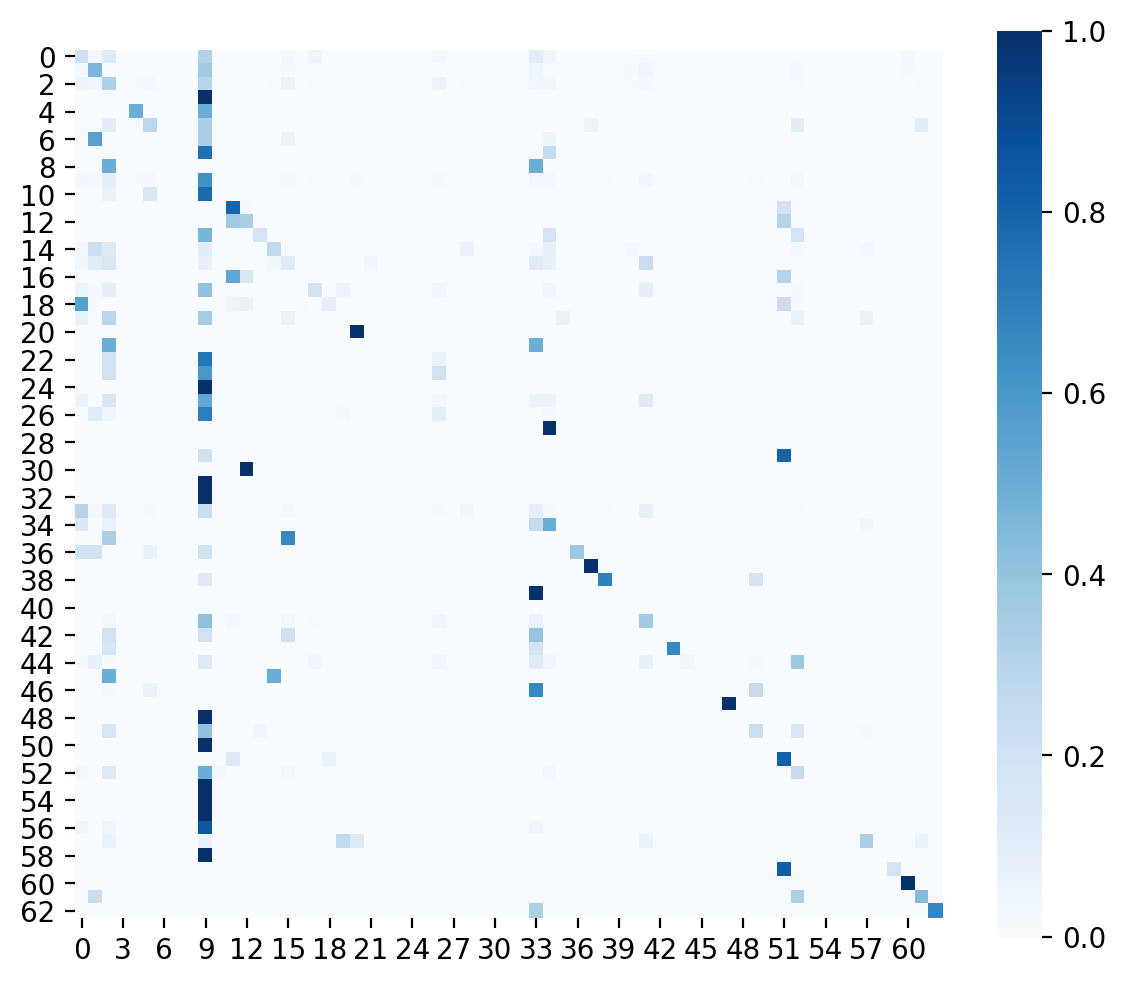

epoch 000 | lr 0.01000 | loss 3.33826 | loss_std 0.61351 | train_score 0.22926
epoch 001 | lr 0.00950 | loss 2.58819 | loss_std 0.14509 | train_score 0.35115
epoch 002 | lr 0.00903 | loss 2.21959 | loss_std 0.11852 | train_score 0.42973
epoch 003 | lr 0.00857 | loss 1.88947 | loss_std 0.09296 | train_score 0.49425
epoch 004 | lr 0.00815 | loss 1.63978 | loss_std 0.05625 | train_score 0.55541
epoch 005 | lr 0.00774 | loss 1.45495 | loss_std 0.06188 | train_score 0.59398
epoch 006 | lr 0.00735 | loss 1.29625 | loss_std 0.04282 | train_score 0.63042
epoch 007 | lr 0.00698 | loss 1.19589 | loss_std 0.04435 | train_score 0.65004
epoch 008 | lr 0.00663 | loss 1.08521 | loss_std 0.04069 | train_score 0.67675
epoch 009 | lr 0.00630 | loss 0.98979 | loss_std 0.03260 | train_score 0.69966
epoch 010 | lr 0.00599 | loss 0.93029 | loss_std 0.03722 | train_score 0.71407
epoch 011 | lr 0.00569 | loss 0.87183 | loss_std 0.02840 | train_score 0.72896
epoch 012 | lr 0.00540 | loss 0.83606 | loss_std 0.0

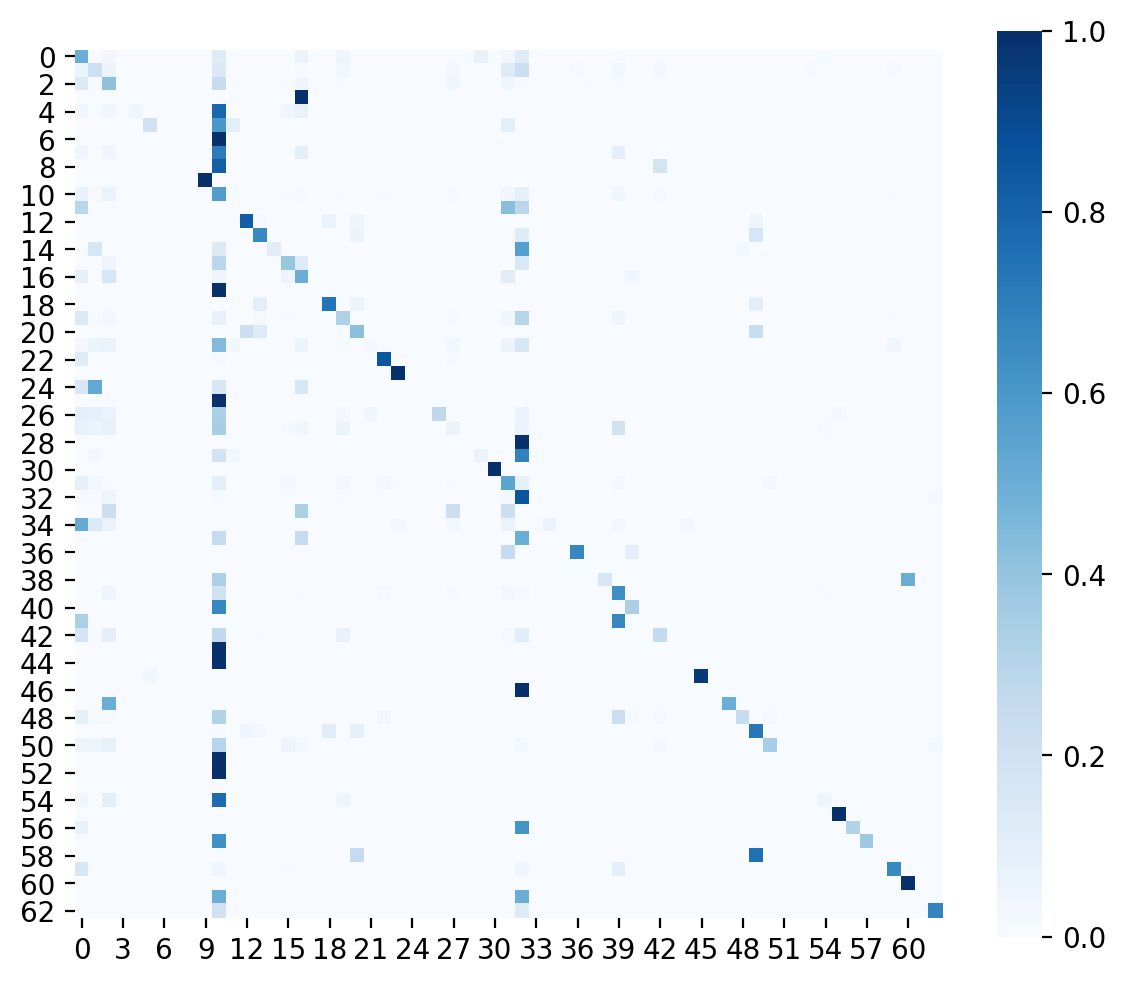

      accuracy  top_5_accuracy
mean  0.460611        0.747756
std   0.079517        0.059570


,accuracy,top_5_accuracy,classifier
0,0.452034,0.765157,Hybrid Res-GCN
1,0.452552,0.705742,Hybrid Res-GCN
2,0.557598,0.821603,Hybrid Res-GCN
3,0.341320,0.670886,Hybrid Res-GCN
4,0.499553,0.775391,Hybrid Res-GCN


In [11]:
p_gcn = graph_level_nn.NodeLevelClassifier(**gcn_default_kwargs, global_node=False, verbose=True)
p_gcn_pipeline = make_pipeline(feature_transformer, p_gcn)

p_gcn_scores = cv_score(p_gcn_pipeline, X=cs_graphs, y=cs_labels, groups=groups, plot_predictions=True)
p_gcn_scores['classifier'] = 'Hybrid Res-GCN'
p_gcn_scores

## Node-level only

In [6]:
nl_gcn = graph_level_nn.NodeLevelClassifier(**gcn_default_kwargs, verbose=True,
                                            hybrid_combination_fun= lambda x, dim: x[:, -1:])
nl_gcn_pipeline = make_pipeline(feature_transformer, nl_gcn)

nl_gcn_scores = cv_score(nl_gcn_pipeline, X=cs_graphs, y=cs_labels, groups=groups)
nl_gcn_scores['classifier'] = 'Node-level Res-GCN'
nl_gcn_scores

epoch 000 | lr 0.01000 | loss 3.28731 | loss_std 0.59986 | train_score 0.25019
epoch 001 | lr 0.00950 | loss 2.39729 | loss_std 0.13842 | train_score 0.39673
epoch 002 | lr 0.00903 | loss 1.99406 | loss_std 0.08212 | train_score 0.47484
epoch 003 | lr 0.00857 | loss 1.71522 | loss_std 0.06050 | train_score 0.53488
epoch 004 | lr 0.00815 | loss 1.52606 | loss_std 0.05258 | train_score 0.57115
epoch 005 | lr 0.00774 | loss 1.38630 | loss_std 0.04718 | train_score 0.60389
epoch 006 | lr 0.00735 | loss 1.27130 | loss_std 0.02942 | train_score 0.62911
epoch 007 | lr 0.00698 | loss 1.17218 | loss_std 0.03193 | train_score 0.64772
epoch 008 | lr 0.00663 | loss 1.11211 | loss_std 0.02733 | train_score 0.66354
epoch 009 | lr 0.00630 | loss 1.06348 | loss_std 0.02107 | train_score 0.67170
epoch 010 | lr 0.00599 | loss 1.01796 | loss_std 0.02233 | train_score 0.68219
epoch 011 | lr 0.00569 | loss 0.96678 | loss_std 0.02153 | train_score 0.68949
epoch 012 | lr 0.00540 | loss 0.92581 | loss_std 0.0

epoch 002 | lr 0.00903 | loss 2.14128 | loss_std 0.09215 | train_score 0.44234
epoch 003 | lr 0.00857 | loss 1.83951 | loss_std 0.05476 | train_score 0.50856
epoch 004 | lr 0.00815 | loss 1.62997 | loss_std 0.05715 | train_score 0.55022
epoch 005 | lr 0.00774 | loss 1.47657 | loss_std 0.03696 | train_score 0.58440
epoch 006 | lr 0.00735 | loss 1.35397 | loss_std 0.04490 | train_score 0.60984
epoch 007 | lr 0.00698 | loss 1.25781 | loss_std 0.03597 | train_score 0.62361
epoch 008 | lr 0.00663 | loss 1.18238 | loss_std 0.02961 | train_score 0.63815
epoch 009 | lr 0.00630 | loss 1.12659 | loss_std 0.03684 | train_score 0.65008
epoch 010 | lr 0.00599 | loss 1.09773 | loss_std 0.04555 | train_score 0.65725
epoch 011 | lr 0.00569 | loss 1.02918 | loss_std 0.01923 | train_score 0.67391
epoch 012 | lr 0.00540 | loss 1.00310 | loss_std 0.03651 | train_score 0.67475
epoch 013 | lr 0.00513 | loss 0.95397 | loss_std 0.01970 | train_score 0.68876
epoch 014 | lr 0.00488 | loss 0.93443 | loss_std 0.0

epoch 004 | lr 0.00815 | loss 1.40514 | loss_std 0.04625 | train_score 0.60268
epoch 005 | lr 0.00774 | loss 1.26525 | loss_std 0.03741 | train_score 0.63434
epoch 006 | lr 0.00735 | loss 1.17654 | loss_std 0.02604 | train_score 0.65508
epoch 007 | lr 0.00698 | loss 1.12167 | loss_std 0.04713 | train_score 0.66067
epoch 008 | lr 0.00663 | loss 1.07394 | loss_std 0.02653 | train_score 0.67386
epoch 009 | lr 0.00630 | loss 1.01284 | loss_std 0.03498 | train_score 0.68335
epoch 010 | lr 0.00599 | loss 0.97026 | loss_std 0.02239 | train_score 0.69433
epoch 011 | lr 0.00569 | loss 0.91148 | loss_std 0.02564 | train_score 0.70856
epoch 012 | lr 0.00540 | loss 0.89597 | loss_std 0.01713 | train_score 0.70620
epoch 013 | lr 0.00513 | loss 0.85602 | loss_std 0.01306 | train_score 0.71425
epoch 014 | lr 0.00488 | loss 0.82739 | loss_std 0.02549 | train_score 0.72170
epoch 015 | lr 0.00463 | loss 0.82289 | loss_std 0.02187 | train_score 0.72372
epoch 016 | lr 0.00440 | loss 0.80135 | loss_std 0.0

,accuracy,top_5_accuracy,classifier
0,0.482732,0.787797,Node-level Res-GCN
1,0.445375,0.722089,Node-level Res-GCN
2,0.571957,0.797781,Node-level Res-GCN
3,0.413201,0.664557,Node-level Res-GCN
4,0.484787,0.800895,Node-level Res-GCN


## Graph-level only

In [6]:
gl_gcn = graph_level_nn.GraphLevelClassifier(**gcn_default_kwargs, verbose=True)
gl_gcn_pipeline = make_pipeline(feature_transformer, gl_gcn)

gl_gcn_scores = cv_score(gl_gcn_pipeline, X=cs_graphs, y=cs_labels, groups=groups)
gl_gcn_scores['classifier'] = 'Graph-level Res-GCN'
gl_gcn_scores

epoch 000 | lr 0.01000 | loss 3.51114 | loss_std 0.57009 | train_score 0.21145
epoch 001 | lr 0.00950 | loss 2.89089 | loss_std 0.04443 | train_score 0.24775
epoch 002 | lr 0.00903 | loss 2.77753 | loss_std 0.01982 | train_score 0.25737
epoch 003 | lr 0.00857 | loss 2.70133 | loss_std 0.02342 | train_score 0.26209
epoch 004 | lr 0.00815 | loss 2.64981 | loss_std 0.02089 | train_score 0.26881
epoch 005 | lr 0.00774 | loss 2.59941 | loss_std 0.02941 | train_score 0.27678
epoch 006 | lr 0.00735 | loss 2.55353 | loss_std 0.01433 | train_score 0.28361
epoch 007 | lr 0.00698 | loss 2.49982 | loss_std 0.02853 | train_score 0.29173
epoch 008 | lr 0.00663 | loss 2.43858 | loss_std 0.01601 | train_score 0.30829
epoch 009 | lr 0.00630 | loss 2.38229 | loss_std 0.03637 | train_score 0.31541
epoch 010 | lr 0.00599 | loss 2.35081 | loss_std 0.02057 | train_score 0.32726
epoch 011 | lr 0.00569 | loss 2.27284 | loss_std 0.02481 | train_score 0.35437
epoch 012 | lr 0.00540 | loss 2.18358 | loss_std 0.0

epoch 002 | lr 0.00903 | loss 2.77065 | loss_std 0.01409 | train_score 0.27120
epoch 003 | lr 0.00857 | loss 2.68044 | loss_std 0.01586 | train_score 0.28338
epoch 004 | lr 0.00815 | loss 2.62635 | loss_std 0.02546 | train_score 0.28530
epoch 005 | lr 0.00774 | loss 2.58441 | loss_std 0.01928 | train_score 0.28859
epoch 006 | lr 0.00735 | loss 2.53634 | loss_std 0.02162 | train_score 0.29873
epoch 007 | lr 0.00698 | loss 2.48440 | loss_std 0.02489 | train_score 0.31050
epoch 008 | lr 0.00663 | loss 2.47117 | loss_std 0.03210 | train_score 0.30742
epoch 009 | lr 0.00630 | loss 2.41500 | loss_std 0.02317 | train_score 0.32233
epoch 010 | lr 0.00599 | loss 2.36797 | loss_std 0.01127 | train_score 0.33510
epoch 011 | lr 0.00569 | loss 2.32039 | loss_std 0.04296 | train_score 0.34308
epoch 012 | lr 0.00540 | loss 2.22895 | loss_std 0.04278 | train_score 0.37020
epoch 013 | lr 0.00513 | loss 2.22637 | loss_std 0.07419 | train_score 0.36663
epoch 014 | lr 0.00488 | loss 2.10125 | loss_std 0.0

epoch 004 | lr 0.00815 | loss 2.58620 | loss_std 0.02550 | train_score 0.28953
epoch 005 | lr 0.00774 | loss 2.52916 | loss_std 0.02942 | train_score 0.30601
epoch 006 | lr 0.00735 | loss 2.41447 | loss_std 0.06341 | train_score 0.34134
epoch 007 | lr 0.00698 | loss 2.29926 | loss_std 0.04047 | train_score 0.37704
epoch 008 | lr 0.00663 | loss 2.17400 | loss_std 0.06344 | train_score 0.41193
epoch 009 | lr 0.00630 | loss 2.02478 | loss_std 0.04321 | train_score 0.44526
epoch 010 | lr 0.00599 | loss 1.96208 | loss_std 0.07641 | train_score 0.45160
epoch 011 | lr 0.00569 | loss 1.81665 | loss_std 0.05637 | train_score 0.48957
epoch 012 | lr 0.00540 | loss 1.69768 | loss_std 0.02815 | train_score 0.51862
epoch 013 | lr 0.00513 | loss 1.59677 | loss_std 0.06029 | train_score 0.54294
epoch 014 | lr 0.00488 | loss 1.51775 | loss_std 0.04361 | train_score 0.56103
epoch 015 | lr 0.00463 | loss 1.45400 | loss_std 0.03119 | train_score 0.57484
epoch 016 | lr 0.00440 | loss 1.41172 | loss_std 0.0

,accuracy,top_5_accuracy,classifier
0,0.272832,0.598619,Graph-level Res-GCN
1,0.298644,0.568182,Graph-level Res-GCN
2,0.297291,0.672142,Graph-level Res-GCN
3,0.195750,0.498644,Graph-level Res-GCN
4,0.283221,0.584787,Graph-level Res-GCN
